In [1]:
import missingno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

In [2]:
df_train = pd.read_csv("../datasets/train_processed.csv", index_col=0)
df_new = df_train.drop(["Next_Tmin", "Next_Tmax"], axis=1)

df_val = pd.read_csv("../datasets/val_processed.csv", index_col=0)
df_val_save = df_val.drop(["Next_Tmin", "Next_Tmax"], axis=1)

df_test = pd.read_csv("../datasets/test_processed.csv", index_col=0)
df_test_save = df_test.drop(["Next_Tmin", "Next_Tmax"], axis=1)

df_train

,station,Present_Tmax,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC2,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lon,Slope,Solar radiation,Next_Tmin,Next_Tmax
2798,24.0,25.3,53.098980,88.314713,28.838707,22.714764,4.491992,35.357061,0.397159,0.536422,0.217628,0.000000,0.000000,0.000000,126.909,0.2223,4849.283203,22.9,28.9
1429,5.0,30.0,57.957870,88.353050,28.629040,22.664603,5.869879,89.331824,0.218586,0.001589,0.000000,0.000000,0.007546,0.000000,127.135,0.5055,4563.660156,21.5,31.4
4835,11.0,32.6,37.920181,77.275185,33.550047,24.529717,6.451454,71.790871,0.015765,0.278280,0.000000,0.000000,0.000000,0.000000,127.085,0.6233,5795.268066,22.2,33.6
5434,10.0,30.0,66.996681,95.048515,26.293850,23.365634,4.801002,34.452793,0.790333,0.787790,4.833832,2.626041,0.000000,0.029888,126.955,5.1782,5352.822754,22.2,31.1
7260,11.0,31.3,54.651810,80.519485,28.943090,24.040451,6.525222,49.586287,0.356729,0.679298,0.000000,0.000000,0.000000,0.000000,127.085,0.6233,5102.056152,23.8,28.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6980,6.0,33.5,49.282288,84.976288,34.561699,26.705811,5.534268,81.235738,0.229199,0.464349,0.000000,0.000000,0.000000,12.055163,127.042,0.1457,5404.668457,26.7,33.4
5723,24.0,34.8,46.886745,84.179184,34.680169,28.586751,6.206956,57.148986,0.013230,0.010946,0.000000,0.000000,0.000000,0.000000,126.909,0.2223,5047.767578,27.7,35.6
5264,15.0,31.8,51.766171,82.884941,32.157013,27.149286,8.539820,32.274478,0.126622,0.101377,0.006876,0.000000,0.000000,0.000000,126.937,0.8552,5538.563477,25.1,32.1
2835,11.0,24.7,57.398273,93.838325,28.527854,22.080858,6.573750,38.056711,0.278724,0.151631,0.005907,0.000000,0.000000,0.000000,127.085,0.6233,4804.658203,20.6,29.4


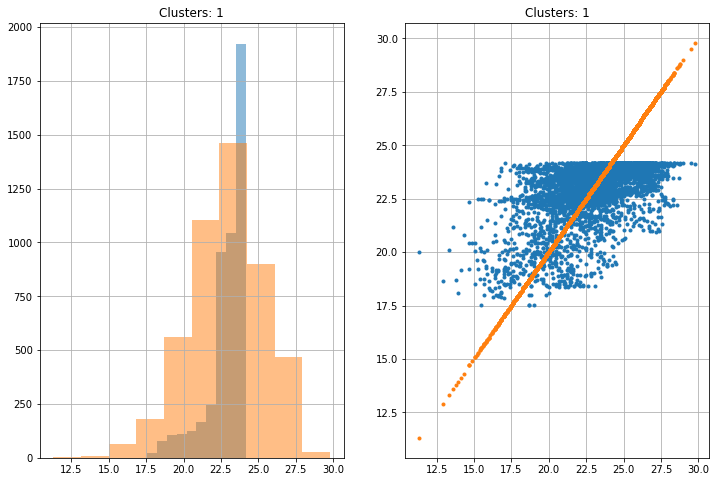

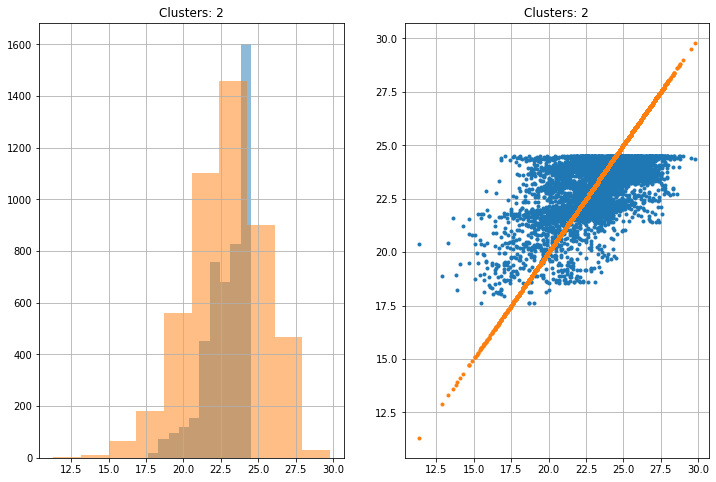

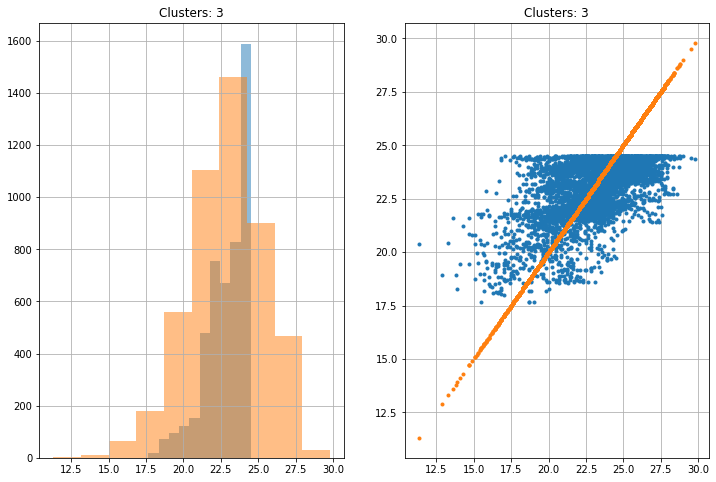

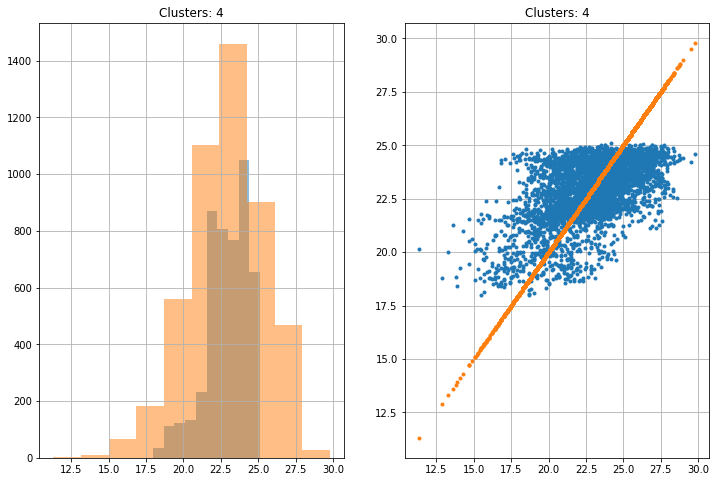

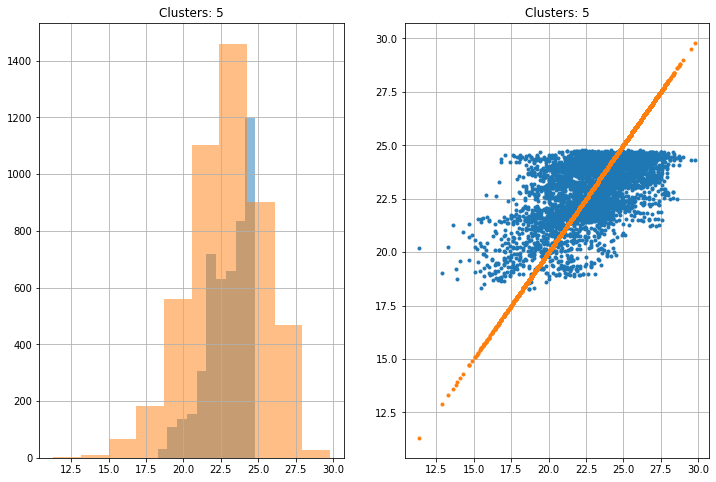

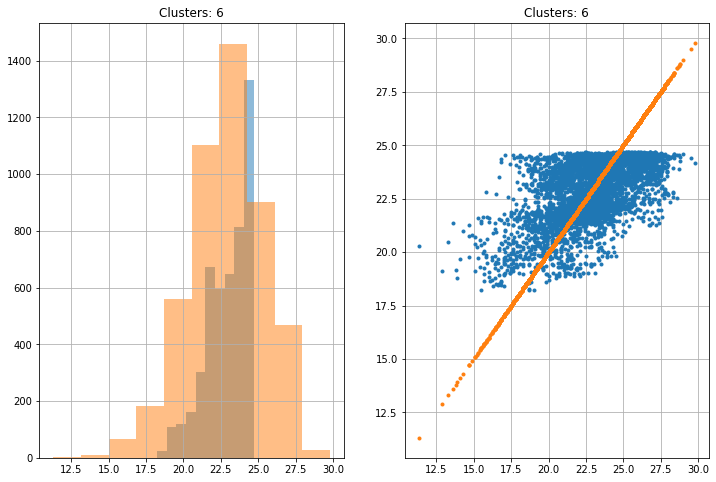

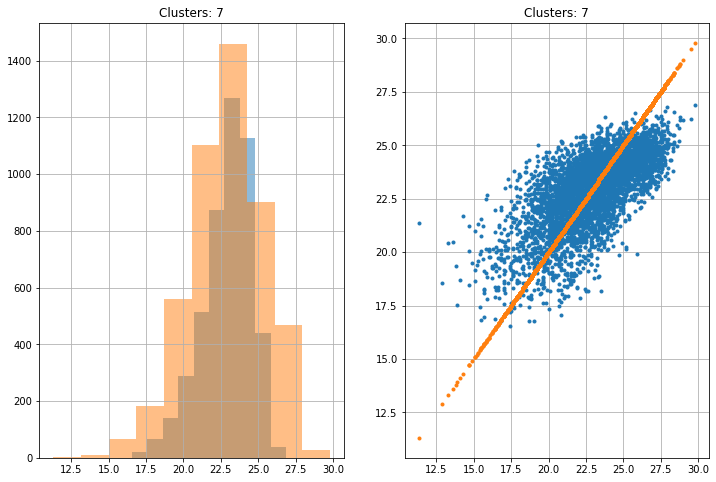

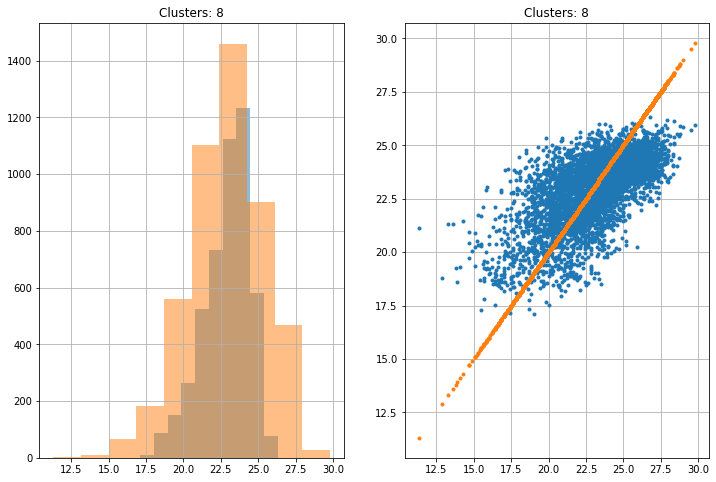

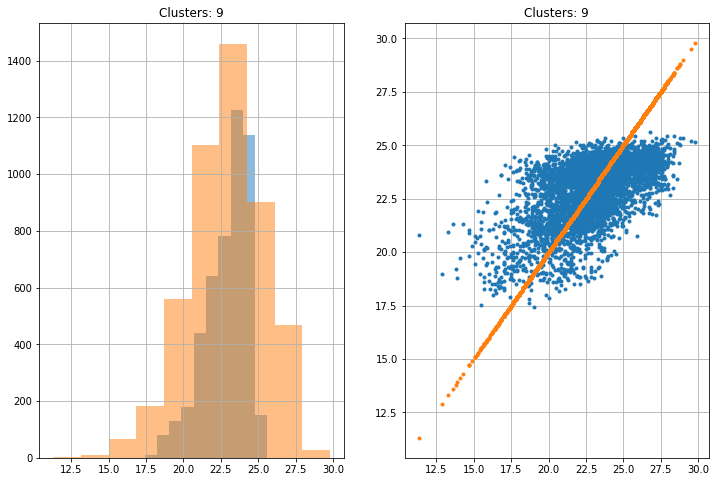

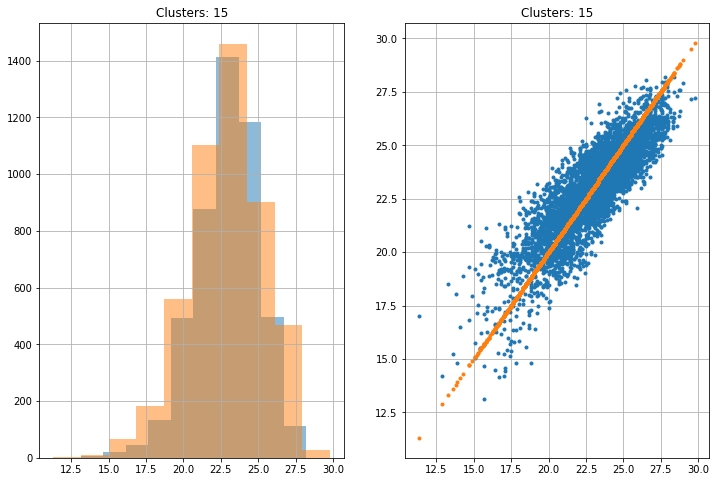

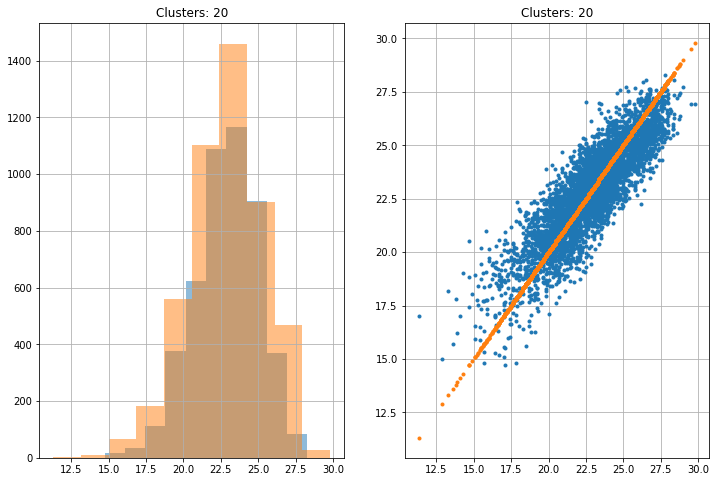

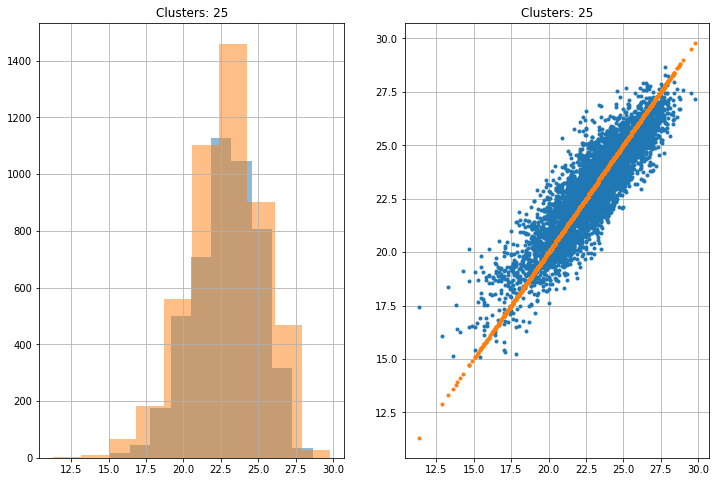

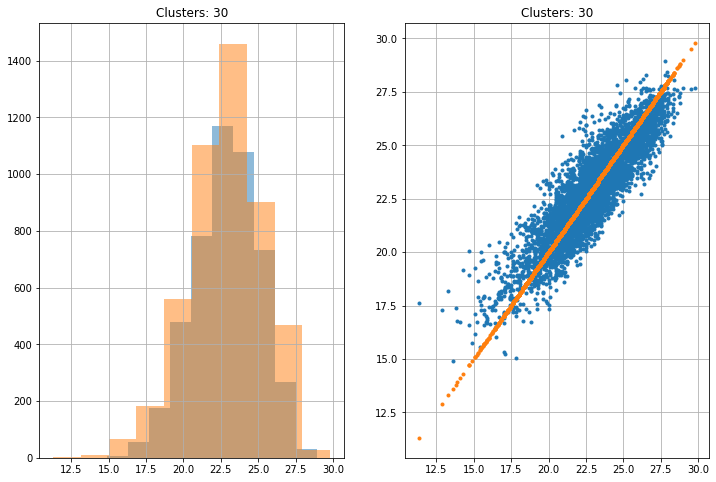

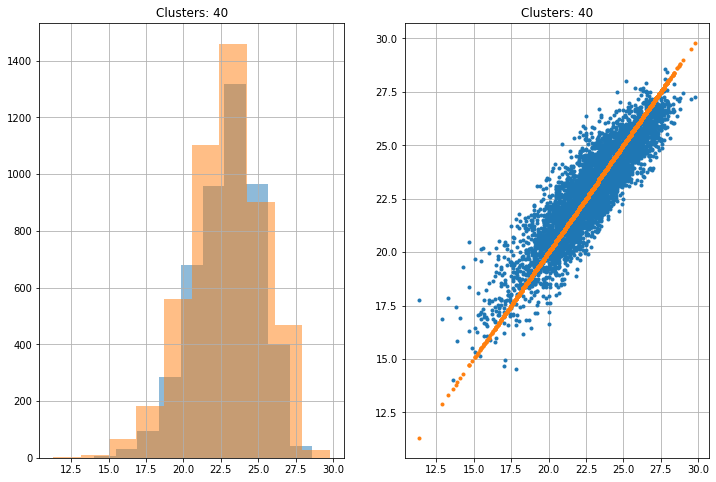

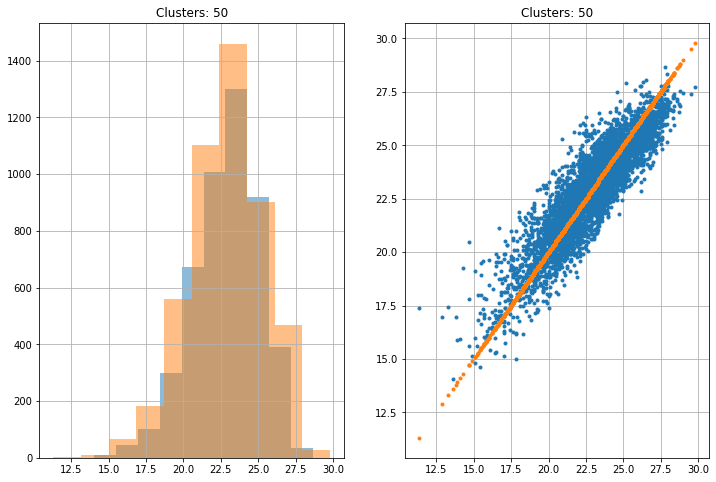

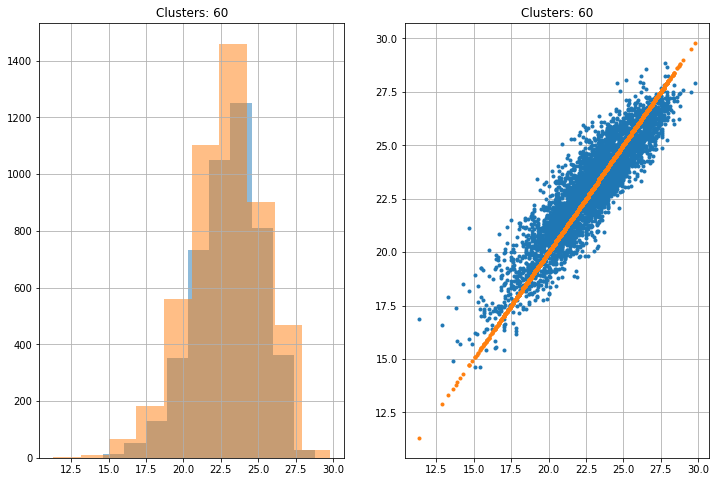

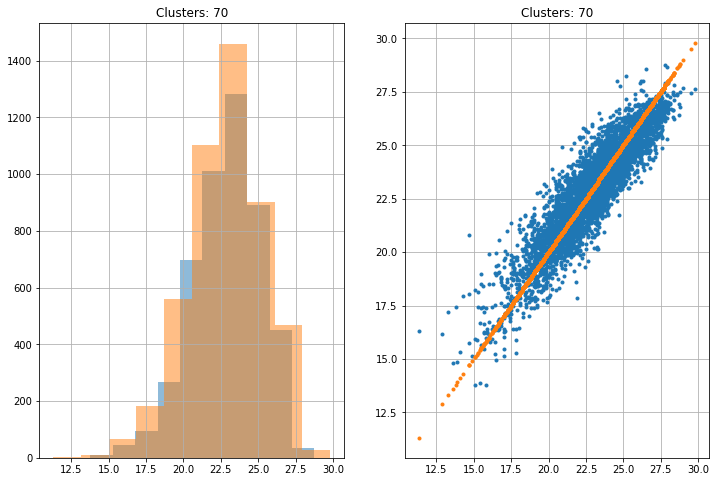

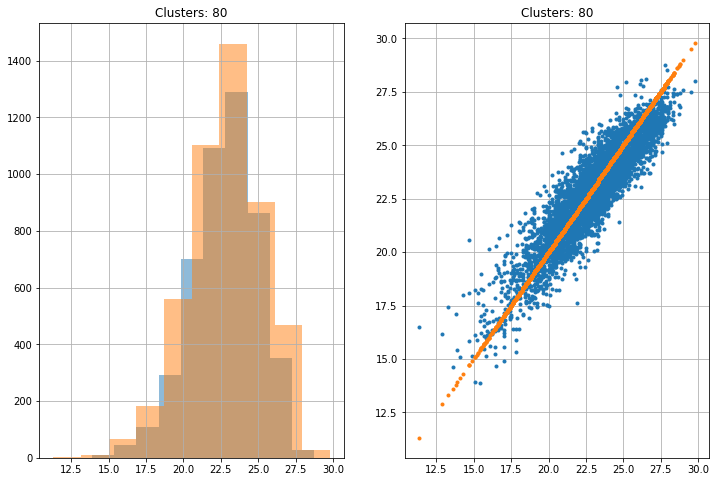

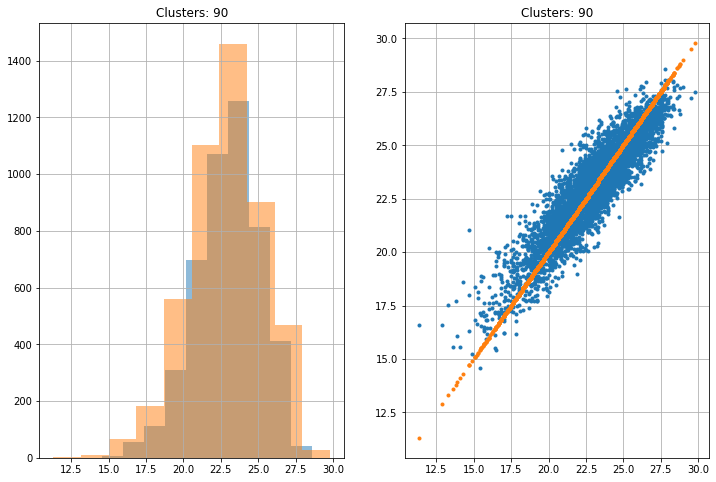

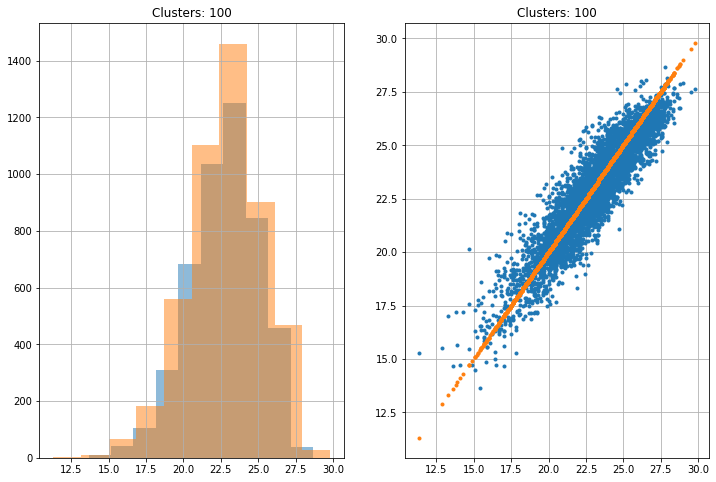

In [3]:
from sklearn.cluster import KMeans

num_clusters = [1]
num_clusters.extend(range(2,10))
num_clusters.extend(range(15, 31, 5))
num_clusters.extend(range(40, 101, 10))

kmeans_list = []
sse_list = []
label_list = []
val_label_list = []
cluster_centers_list = []
error_list = []
val_error_list = []

for n_clu in num_clusters:
    kmeans = KMeans(n_clusters=n_clu, random_state=42).fit(df_new.to_numpy())
    kmeans_list.append(kmeans)
    sse_list.append(kmeans.inertia_)
    label_list.append(kmeans.labels_)
    cluster_centers_list.append(kmeans.cluster_centers_)  

    mean_centers = cluster_centers_list[-1]
    corresponding_center = mean_centers[label_list[-1],:]

    X = df_new.to_numpy()
    X_val = df_val_save.to_numpy()
    val_labels = kmeans.predict(X_val)
    val_label_list.append(val_labels)
    
    distance = np.linalg.norm(X-corresponding_center, axis=1)
    var = np.var(distance)*distance.size

    phi = np.ones((X.shape[0], 1))
    phi_val = np.ones((X_val.shape[0], 1))
    
    for i in range(n_clu):
        A = X-mean_centers[i,:]
        A = np.exp(-np.linalg.norm(X-mean_centers[i,:], axis=1)**2/var)
        
        B = X_val-mean_centers[i,:]
        B = np.exp(-np.linalg.norm(X_val-mean_centers[i,:], axis=1)**2/var)
        
        phi = np.append(phi, np.exp(-np.linalg.norm(X-mean_centers[i,:], axis=1)**2/var).reshape(-1,1), axis=1)
        phi_val = np.append(phi_val, np.exp(-np.linalg.norm(X_val-mean_centers[i,:], axis=1)**2/var).reshape(-1,1), axis=1)

    lmbda = 0
    W1 = (np.linalg.inv(phi.T @ phi + lmbda*np.identity(phi.shape[1])) @ phi.T) @ df_train["Next_Tmin"]
    W1 = W1.reshape(-1,1)
    pred = phi @ W1
    val_pred = phi_val @ W1

    plt.figure(figsize=[12,8])
    plt.title("Clusters: "+str(n_clu))
    plt.subplot(1, 2, 1)
    plt.hist(pred, alpha=0.5)
    plt.hist(df_train["Next_Tmin"], alpha=0.5)
    plt.title("Clusters: "+str(n_clu))
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(df_train["Next_Tmin"], pred, ".")
    plt.plot(df_train["Next_Tmin"], df_train["Next_Tmin"], '.')
    plt.title("Clusters: "+str(n_clu))
    plt.grid()
    plt.show()

    error = np.linalg.norm(df_train["Next_Tmin"].to_numpy().reshape(-1,1)-pred)
    error_list.append(error)
    
    val_error = np.linalg.norm(df_val["Next_Tmin"].to_numpy().reshape(-1,1)-val_pred)
    val_error_list.append(val_error)

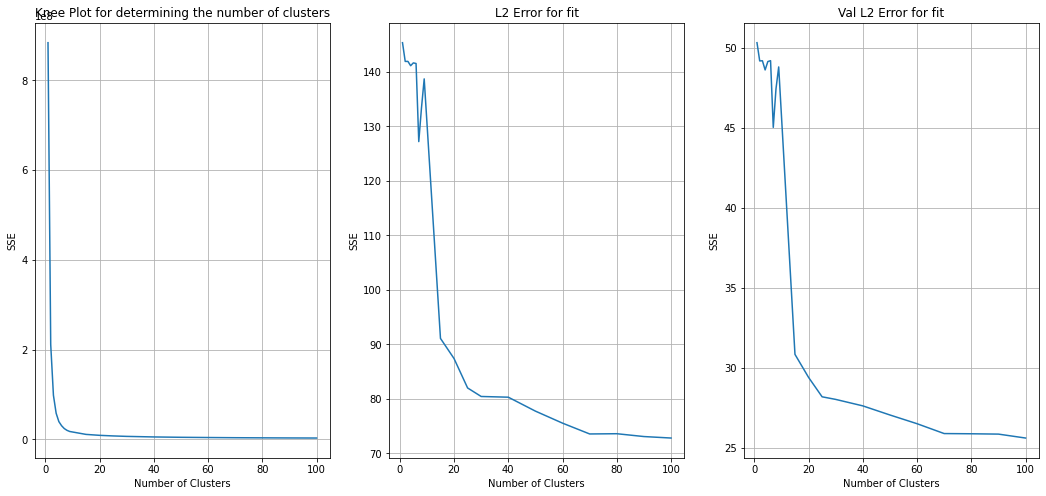

In [4]:
plt.figure(figsize=[18,8])
plt.subplot(1,3,1)
plt.plot(num_clusters, sse_list)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Knee Plot for determining the number of clusters")
plt.grid()
plt.subplot(1,3,2)
plt.plot(num_clusters, error_list)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title(("L2 Error for fit"))
plt.grid()
plt.subplot(1,3,3)
plt.plot(num_clusters, val_error_list)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title(("Val L2 Error for fit"))
plt.grid()
plt.show()
plt.show()

In [5]:
error_list = np.array(error_list)
val_error_list = np.array(val_error_list)
df_error = pd.DataFrame({"Clusters":num_clusters, "Error":error_list, "Validation Error":val_error_list})
df_error.sort_values(by=["Validation Error"], ascending=True, inplace=True)
display(df_error)

,Clusters,Error,Validation Error
19,100,72.824098,25.633314
18,90,73.095970,25.878555
17,80,73.616123,25.899348
16,70,73.570952,25.912513
15,60,75.552741,26.528723
14,50,77.758687,27.073973
13,40,80.314602,27.642797
12,30,80.444922,28.047518
11,25,82.007777,28.209810
10,20,87.401401,29.426169


In [6]:
best_cluster = df_error.iloc[0]["Clusters"]
pos = num_clusters.index(best_cluster)
best_centers = cluster_centers_list[pos]
best_centers.shape

print(best_cluster, best_centers.shape)

100.0 (100, 17)


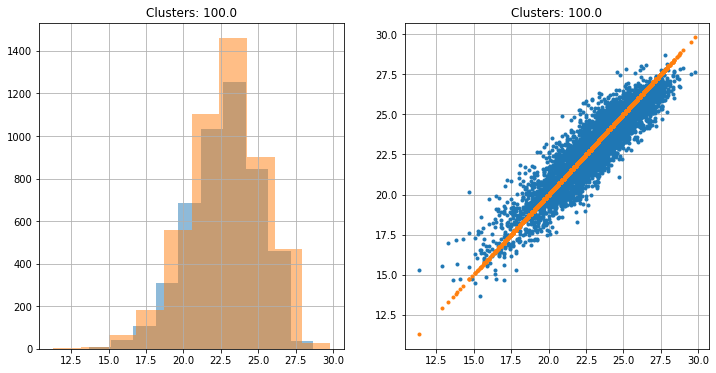

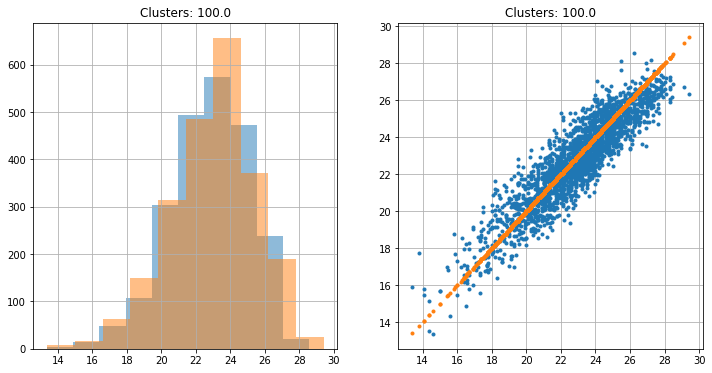

Test SSE: 51.22533945029685


In [9]:
kmeans = kmeans_list[pos]
best_centers = cluster_centers_list[pos]
corresponding_center = best_centers[label_list[pos],:]

X = df_new.to_numpy()
X_val = df_val_save.to_numpy()
X_test = df_test_save.to_numpy()
val_labels = val_label_list[pos]
test_labels = kmeans.predict(X_test)

distance = np.linalg.norm(X-corresponding_center, axis=1)
var = np.var(distance)*distance.size

phi = np.ones((X.shape[0], 1))
phi_val = np.ones((X_val.shape[0], 1))
phi_test = np.ones((X_test.shape[0], 1))

for i in range(int(best_cluster)):
    A = X-best_centers[i,:]
    A = np.exp(-np.linalg.norm(X-best_centers[i,:], axis=1)**2/var)

    B = X_val-best_centers[i,:]
    B = np.exp(-np.linalg.norm(X_val-best_centers[i,:], axis=1)**2/var)
    
    c = X_test-best_centers[i,:]
    c = np.exp(-np.linalg.norm(X_test-best_centers[i,:], axis=1)**2/var)

    phi = np.append(phi, np.exp(-np.linalg.norm(X-best_centers[i,:], axis=1)**2/var).reshape(-1,1), axis=1)
    phi_val = np.append(phi_val, np.exp(-np.linalg.norm(X_val-best_centers[i,:], axis=1)**2/var).reshape(-1,1), axis=1)
    phi_test = np.append(phi_test, np.exp(-np.linalg.norm(X_test-best_centers[i,:], axis=1)**2/var).reshape(-1,1), axis=1)

lmbda = 0
W1 = (np.linalg.inv(phi.T @ phi + lmbda*np.identity(phi.shape[1])) @ phi.T) @ df_train["Next_Tmin"]
W1 = W1.reshape(-1,1)
pred = phi @ W1
val_pred = phi_val @ W1
test_pred = phi_test @ W1

plt.figure(figsize=[12,6])
plt.title("Clusters: "+str(best_cluster))
plt.subplot(1, 2, 1)
plt.hist(pred, alpha=0.5)
plt.hist(df_train["Next_Tmin"], alpha=0.5)
plt.title("Clusters: "+str(best_cluster))
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(df_train["Next_Tmin"], pred, ".")
plt.plot(df_train["Next_Tmin"], df_train["Next_Tmin"], '.')
plt.title("Clusters: "+str(best_cluster))
plt.grid()
plt.show()

plt.figure(figsize=[12,6])
plt.title("Clusters: "+str(best_cluster))
plt.subplot(1, 2, 1)
plt.hist(test_pred, alpha=0.5)
plt.hist(df_test["Next_Tmin"], alpha=0.5)
plt.title("Clusters: "+str(best_cluster))
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(df_test["Next_Tmin"], test_pred, ".")
plt.plot(df_test["Next_Tmin"], df_test["Next_Tmin"], '.')
plt.title("Clusters: "+str(best_cluster))
plt.grid()
plt.show()

test_error = np.linalg.norm(df_test["Next_Tmin"].to_numpy().reshape(-1,1)-test_pred)
print("Test SSE:", test_error)

In [10]:
df_test.shape, df_train.shape

((2277, 19), (4779, 19))